# Exporting actors as TF-features

This notebook exports a corrected version of the participant reference dataset created by Eep Talstra. That dataset was inspected and a list of mismatches was identified for manual correction (see [notebook](https://github.com/ch-jensen/Semantic-mapping-of-participants/blob/master/2_Exploring%20the%20dataset.ipynb)). The dataset went through two rounds of corrections in Excel. This corrected version will now be exported as three [text-fabric](https://dans-labs.github.io/text-fabric/) features:

1. *actor* (actors for words, phrase atoms and subphrases)
2. *prs_actor* (actors for pronominal suffixes)
3. *coref* (an edge feature linking each reference to its respective co-references)

## 1. Importing

### 1.1. Importing modules

In [1]:
PATH = 'Datasets/'

import sys, os
import csv, collections
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from tf.app import use
A = use('bhsa', hoist=globals(), locations='actor/tf')

rate limit is 60 requests per hour, with 60 left for this hour
To increase the rate,see https://annotation.github.io/text-fabric/Api/Repo/
	connecting to online GitHub repo annotation/app-bhsa ... connected
Using TF-app in C:\Users\Ejer/text-fabric-data/annotation/app-bhsa/code:
	rv2.0.0=#7b3b9ffba7ee6dbc76a52b8d76475d17babf0daf (latest release)
rate limit is 60 requests per hour, with 55 left for this hour
To increase the rate,see https://annotation.github.io/text-fabric/Api/Repo/
	connecting to online GitHub repo etcbc/bhsa ... connected
Using data in C:\Users\Ejer/text-fabric-data/etcbc/bhsa/tf/c:
	rv1.6=#bac4a9f5a2bbdede96ba6caea45e762fe88f88c5 (latest release)
rate limit is 60 requests per hour, with 50 left for this hour
To increase the rate,see https://annotation.github.io/text-fabric/Api/Repo/
	connecting to online GitHub repo etcbc/phono ... connected
Using data in C:\Users\Ejer/text-fabric-data/etcbc/phono/tf/c:
	r1.2=#1ac68e976ee4a7f23eb6bb4c6f401a033d0ec169 (latest release)

### 1.2. Importing corrected dataset

In [3]:
file = f'{PATH}Lev17toLev26_mapped_updated_corrected.csv'

new_dict = {}

n = 0

with open(file) as f:
    next(f)
    reader = csv.reader(f, delimiter = ';')
    for r in reader:
        surface_text = r[1]
        book = r[2]
        chapter = r[3]
        verse = r[4]
        clause_atom = r[5]
        pred = r[6]
        ref = r[7]
        ptc_set = r[8]
        ptc_actor = r[9]
        slots = r[10]
        func = r[11]
        compound = r[12]
        correction_1 = r[14]
        correction_2 = r[15]
        n+=1
        
        new_dict[n] = [surface_text, book, chapter, verse, clause_atom, pred, ref, 
                       ptc_set, ptc_actor, slots, func, compound, correction_1, correction_2]

In [4]:
data = pd.DataFrame.from_dict(new_dict).T
data.columns = ['surface_text','book','chapter','verse','clause_atom','predicate','reference','participant',
                'actor','slots','func','compound','1_correction','2_correction']

## 2. Implement corrections:

How many corrections have been made?

In [8]:
rows_total = len(data)

print(f"First round: {rows_total-len(data[data['1_correction'] == ''])}")
print(f"Second round: {rows_total-len(data[data['2_correction'] == ''])}")

First round: 235
Second round: 715


How are the corrections distributed in the dataset:

In [9]:
cor_dict = collections.defaultdict(lambda: collections.defaultdict(int))

for row in data.iterrows():
    chapter = data['chapter'][row[0]]
    
    cor_dict[chapter]['length'] += 1
    
    if data['1_correction'][row[0]]:
        cor_dict[chapter]['1_cor'] += 1
        
    if data['2_correction'][row[0]]:
        cor_dict[chapter]['2_cor'] += 1
    
#cor_dict

In [10]:
data_cor = pd.DataFrame.from_dict(cor_dict, orient='index')

#data_cor

In [11]:
prop_1_cor = data_cor['1_cor']/data_cor.length*100
prop_2_cor = data_cor['2_cor']/data_cor.length*100

prop_table = pd.concat([prop_1_cor, prop_2_cor], axis=1, sort=False)
prop_table.columns = ['1st correction','2nd correction']

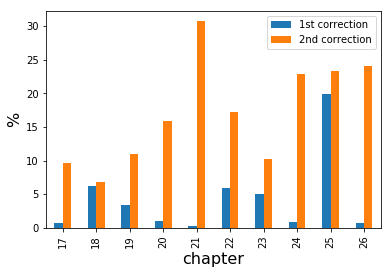

In [12]:
plot = prop_table.plot(kind='bar')
plt.ylabel('%', fontsize=16)
plt.xlabel('chapter', fontsize=16)
plt.rcParams["figure.figsize"] = [8,6]
plt.show()

The manual corrections are incorporated in following order: First, it is checked whether a correction from 2. correction round exists, and thereafter if a correction from 1. correction round exists. If one of these exists (2. round has priority), it will overwrite the actor in the 'actor' column.

In [13]:
for row in data.iterrows():
    row = row[0]
    actor = data['actor'][row]
    correction_1 = data['1_correction'][row]
    correction_2 = data['2_correction'][row]
    
    if correction_2 != '':
        actor = correction_2
    elif correction_1 != '':
        actor = correction_1
        
    data['actor'][row] = actor #Update dataframe

The columns '1_correction' and '2_correction' can now be dropped:

In [14]:
data = data.drop(columns=['1_correction', '2_correction']) #drop columns
data['otype'] = '...'

In [15]:
data

,surface_text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound,otype
1,JDBR,Leviticus,17,1,528163,DBR,DBR,3sm=JHWH,JHWH,63009,VbPred,0,...
2,JHWH,Leviticus,17,1,528163,DBR,JHWH,3sm=JHWH,JHWH,63010,Subj,1,...
3,>L MCH,Leviticus,17,1,528163,DBR,>L MCH,0sm=MCH,MCH,63011 63012,Compl1,2,...
4,L->MR,Leviticus,17,1,528164,>MR,L >MR,3sm=JHWH,JHWH,63013 63014,VbPred,3,...
5,DBR,Leviticus,17,2,528165,DBR,DBR,2sm=,MCH,63015,VbPred,4,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4088,JFR>L,Leviticus,26,46,529382,NTN,JFR>L,...,...,68959,#NAVN?,4087,...
4089,B-HR SJNJ,Leviticus,26,46,529382,NTN,B HR SJNJ,...,...,68960 68961 68962,Locat,4088 4089,...
4090,SJNJ,Leviticus,26,46,529382,NTN,SJNJ,...,...,68962,#NAVN?,4089,...
4091,B-JD MCH,Leviticus,26,46,529382,NTN,B JD MCH,...,...,68963 68964 68965,Adjunc,4090 4091,...


In [16]:
actor = data.actor
counter = collections.Counter(actor)
df = pd.DataFrame.from_dict(counter, orient='index')
df.columns = ['frequency']
df.sort_values(by='frequency', ascending=False)[:21]

,frequency
...,783
JHWH,432
BN JFR>L,337
>JC,162
>TM,134
"2sm""YOUSgmas""",128
>RY,77
">X ""YOUSgmas""",69
"""YOUSgmas""",67
MCH,61


### 2.1. Finding nearest object type

When exporting the actor references as TF-features, we need to know what object (word, phrase etc.) the actor reference applies to. That information does not exist directly in the dataset, as the actors are only related to an interval of slots. The following function finds the nearest object type in terms of slots occupied. The algorithm goes from the smallest type (suffix) to the larger types (subphrases and phrases). At each step, it is checked whether the first word and the last word of any given object match the first and last words of the actor reference:

In [17]:
def nearestObject(row):
    '''
    Input: row number
    Output: the TF-object type that comes closest to the interval of words that the actor reference occupies.
    '''
    slots = data['slots'][row].split()
    first_word = int(slots[0]) #First word of actor reference
    last_word = int(slots[-1]) #Last word
    
    subphrase = L.u(first_word, 'subphrase') #The subphrase to which the first word belongs
    phrase_atom = L.u(first_word, 'phrase_atom')[0] #The phrase atom to which the first belongs
    
    nearest_object = ''
    
    if data['reference'][row] == 'sfx': #If actor reference is a suffix, it only occupies one word slot.
        nearest_object = first_word
    
    elif subphrase: #If the first word belongs to a subphrase - that's not always the case.
        for ph in subphrase:
            subphrase_words = L.d(ph, 'word')
            #Checking if first word and last word of the actor match those of the subphrase.
            if subphrase_words[0] == first_word and subphrase_words[-1] == last_word:
                nearest_object = ph
                
    if nearest_object == '': #If nearest object has not yet been found we check the phrase atom level
        phrase_words = L.d(phrase_atom, 'word')
        if phrase_words[-1] == last_word: #If the last word of the phrase matches the last of the actor, there is a match
            nearest_object = phrase_atom
    
    return nearest_object

#nearestObject(5)

A new column is added to the dataframe in which we add the nodes of the object type matching the slots occupied by the actor reference. If no object type is found, the row is added to an error_list, so possible mismatches can be identified:

In [18]:
error_list = []

for row in data.iterrows():
    if data['actor'][row[0]] != '...': #Empty actors are left out because they are not relevant.
        nearest_object = nearestObject(row[0]) #The function nearestObject() is run for every row.
        if nearest_object == '':
            error_list.append(row[0]) #If there is no object matching the actor, the row is added to an error_list
        else:
            data['otype'][row[0]] = nearest_object #The object type node is added to a column
            
print(f'Number of errors: {len(error_list)}')

Number of errors: 0


In [19]:
data

,surface_text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound,otype
1,JDBR,Leviticus,17,1,528163,DBR,DBR,3sm=JHWH,JHWH,63009,VbPred,0,943175
2,JHWH,Leviticus,17,1,528163,DBR,JHWH,3sm=JHWH,JHWH,63010,Subj,1,943176
3,>L MCH,Leviticus,17,1,528163,DBR,>L MCH,0sm=MCH,MCH,63011 63012,Compl1,2,943177
4,L->MR,Leviticus,17,1,528164,>MR,L >MR,3sm=JHWH,JHWH,63013 63014,VbPred,3,943178
5,DBR,Leviticus,17,2,528165,DBR,DBR,2sm=,MCH,63015,VbPred,4,943179
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4088,JFR>L,Leviticus,26,46,529382,NTN,JFR>L,...,...,68959,#NAVN?,4087,...
4089,B-HR SJNJ,Leviticus,26,46,529382,NTN,B HR SJNJ,...,...,68960 68961 68962,Locat,4088 4089,...
4090,SJNJ,Leviticus,26,46,529382,NTN,SJNJ,...,...,68962,#NAVN?,4089,...
4091,B-JD MCH,Leviticus,26,46,529382,NTN,B JD MCH,...,...,68963 68964 68965,Adjunc,4090 4091,...


In [20]:
nr = 0
for n in data.actor:
    if n not in ['...','…']:
        nr += 1
        
nr

3307

### 2.2. Exporting final dataset

In [21]:
file = f'{PATH}Lev17toLev26_mapped_updated_corrected_final_1.csv'
data.to_csv(file, index=False)

### 2.3. Computing edges

Next, we need to find the edges between co-referring actor references. The principle is to find a list of nodes from the 'otype' column referring to the same actor.

First, we define a function that takes an actor reference and a chapter as input and produces a list of all nodes referring to the same actor based on the dataframe:

In [22]:
def mapActors(actor, chapter):
    '''
    Input: Actor reference (string) and chapter (int)
    Output: List of nodes with the same actor reference in that particular chapter
    '''
    subset_data = data[(data.chapter == str(chapter)) & (data.actor == actor)]
    otype = subset_data.otype.values.tolist()
    
    return otype

#mapActors('MCH',26)

The function above is used to create a dictionary of edges for all actor references in the dataset:

In [23]:
edges_dict = {}

for row in data.iterrows():
    row = row[0]
    actor = data['actor'][row]
    if actor not in ['...']: #Excluding rows with empty actors
        edges = mapActors(actor, data['chapter'][row]) #A list of edges is created with the function mapActors() for each row
        edges.remove(data['otype'][row]) #The present row number is removed from the edges list to avoid redundancy.
        
        #If a set can be made from the edges list, the set is added to the dictionary with the row otype node as key:
        if set(edges):
            edges_dict[data['otype'][row]] = set(edges)

In [24]:
len(edges_dict)

3232

## 3. Exporting as TF features

Now, we can export the actor references and the edge dictionary as TF-features. First, we assign TF version names and paths to ensure the right storage of the features:

In [25]:
if 'SCRIPT' not in locals():
    SCRIPT = False
    FORCE = True
    CORE_NAME = 'bhsa'
    NAME = 'actor'
    VERSION= 'c'
    CORE_MODULE = 'core'

In [26]:
repoBase = os.path.expanduser('~/text-fabric-data/etcbc')
coreTf = '{}/{}/tf/{}'.format(repoBase, CORE_NAME, VERSION) #Path of the core TF datasets
thisTf = '~Feature_sets/{}/tf/{}'.format(NAME, VERSION) #Path of actor datasets

### 3.1. Export lexical and suffix references:

To store the lexical and suffix references as TF-features the information needs to be stored in dictionaries. This is done by looping through the dataset and distinguishing between suffix references and non-suffix references and storing the TF node in the relevant dictionary:

In [27]:
suffix_dict = {}
lexical_dict = {}

for row in data.iterrows():
    row = row[0]
    if data['actor'][row] != '...': #Excluding empty actors
        if data['reference'][row] == 'sfx': #If suffix, the word node (always only one word node) is stored in the dict.
            node = int(data['slots'][row])
            suffix_dict[node] = data['actor'][row]
        else: #If not suffix, the nearest object is found using nearestObject() and the resulting node is stored. 
            node = nearestObject(row)
            lexical_dict[node] = data['actor'][row]

In [28]:
lexical_dict

{943175: 'JHWH',
 943176: 'JHWH',
 943177: 'MCH',
 943178: 'JHWH',
 943179: 'MCH',
 943180: '>HRN BN >HRN BN JFR>L',
 1317252: '>HRN',
 1317253: 'BN >HRN',
 1317258: 'BN JFR>L',
 1317257: 'JFR>L',
 943182: 'MCH',
 943184: 'DBR',
 943185: 'DBR',
 943187: 'JHWH',
 943188: 'JHWH',
 943189: 'JHWH',
 943190: '>JC >JC',
 1317261: '>JC',
 943191: 'BJT JFR>L',
 1317263: 'JFR>L',
 943193: '>JC >JC',
 943194: 'CWR KFB <Z',
 943195: 'MXNH',
 943198: '>JC >JC',
 943200: 'MXNH',
 943202: 'PTX >HL MW<D',
 1317271: '>HL MW<D',
 1317270: 'MW<D',
 943204: '>JC >JC',
 943205: '>JC >JC',
 943207: 'JHWH',
 1317274: 'JHWH',
 943209: 'DM',
 943210: 'DM',
 943211: '>JC >JC',
 943212: 'DM',
 943213: '>JC >JC',
 943215: '>JC >JC',
 943216: '>JC >JC',
 943217: 'QRB <M >JC >JC',
 943219: 'BN JFR>L',
 943220: 'BN JFR>L',
 1317283: 'JFR>L',
 943221: 'ZBX BN JFR>L',
 943223: 'BN JFR>L',
 943224: 'BN JFR>L',
 943227: 'BN JFR>L',
 943228: 'JHWH',
 943229: 'PTX >HL MW<D',
 1317289: '>HL MW<D',
 1317288: 'MW<D',
 94323

#### 3.1.1. Export lexical references

In [29]:
nodeFeatures = dict(actor=lexical_dict)
metaData = dict(
    actor=dict(
        valueType='str',
        description="Participant references for words, subphrases and phrases. The references are adapted from Eep Talstra's work on participant tracking. http://doi.org/10.5281/zenodo.1479491",
        coreData='BHSA',
        coreVersion=VERSION
    )
)
TF.save(nodeFeatures=nodeFeatures, metaData=metaData, module='c')

True

In [30]:
nodeFeatures = dict(prs_actor=suffix_dict)
metaData = dict(
    prs_actor=dict(
        valueType='str',
        description="Participant references for pronominal suffixes. The references are adapted from Eep Talstra's work on participant tracking. http://doi.org/10.5281/zenodo.1479491",
        coreData='BHSA',
        coreVersion=VERSION
    )
)
TF.save(nodeFeatures=nodeFeatures, metaData=metaData, module='c')

True

### 3.2. Export edge features

In [31]:
edgeFeatures = dict(coref=edges_dict)
metaData = dict(
    coref=dict(
        valueType='str',
        description="Edges to co-referring actors on chapter-level. The references are adapted from Eep Talstra's work on participant tracking. http://doi.org/10.5281/zenodo.1479491",
        coreData='BHSA',
        coreVersion=VERSION
    )
)
TF.save(edgeFeatures=edgeFeatures, metaData=metaData, module='c')

True